# Example of XPC on RTE data

This notebook illustrates how to use the XPC package on public RTE data. The dataset only contains the true loads but no true climate and non-climate parts. We will showcase how to train usual machine learning models.

## Loading data and model

### Imports

In [1]:
import os
os.chdir("..") #go to directory containing xpc pacakge

In [2]:
from xpc.utils import data #to load datasets
from xpc.utils import models #to load models
from xpc.utils import series #to manipulate time series
from xpc.utils import plots #to plot time series

from xpc import shapley #to compute Shapley values
from xpc import ale #to draw ALE
from xpc import pdp #to draw PDP

from time import perf_counter 
import numpy as np

### Data

Load the train and test datasets used to train the model

In [4]:
path = "datasets/data_rte"
df_train = data.read_dataset("df_train", path, date_column = "DateTime")
df_test = data.read_dataset("df_test", path, date_column = "DateTime")

print("Train shape: ", df_train.shape)
print("Test shape: ", df_test.shape)

df_train.head()

Train shape:  (11688, 11)
Test shape:  (2920, 11)


,Consommation,Temperature,Humidity,WindSpeed,PositionDansAnnee,JourFerie,VacancesZoneA,VacancesZoneB,VacancesZoneC,Jour,Heure
DateTime,,,,,,,,,,,
2015-01-01 00:00:00,432976.0,5.057414,81.526316,3.096552,0.000143,1,1,1,1,3,0
2015-01-01 03:00:00,395162.0,4.609138,82.456140,3.105172,0.000485,1,1,1,1,3,3
2015-01-01 06:00:00,386741.0,4.729828,81.929825,3.200000,0.000828,1,1,1,1,3,6
2015-01-01 09:00:00,393209.0,6.052241,79.789474,3.101724,0.001170,1,1,1,1,3,9
2015-01-01 12:00:00,398893.0,9.347069,69.649123,3.691379,0.001513,1,1,1,1,3,12


Separate features from load. Train data will be used as to train the model and as "background" for explainability. Test data will be used to score the model and as $X$ to explain.

For visualization purposes, we will sometimes consider $X_{ws}$, a subset of $X$ containing only 1 day in winter and 1 in summer.

In [5]:
#background
background = df_train.drop(columns=["Consommation"])
background_y = df_train.Consommation

#X
X = df_test.drop(columns=["Consommation"])
y = df_test.Consommation

#2 days subsets
Nday = 8 #number of instants per day
T = list(range(Nday)) + list(range(Nday*365//2, Nday*365//2+Nday)) # winter and summer indexes
Xws, yws = X.iloc[T], y.iloc[T]
print("Xws shape: ",Xws.shape)

Xws shape:  (16, 10)


We have to declare which variables are for the climate part and which are non-climate.

Also, we may describe the type for each feature. This will help computing conditional distributions.

In [6]:
col_mapping = {
    "C":["Temperature", "Hummidity","WindSpeed"],
    "NC":["PositionDansAnnee" "JourFerie", "VacancesZoneA", "VacancesZoneB", "VacancesZoneC","Jour","Heure"],
}


feature_types = {
    "Temperature":"continuous",
    "Hummidity":"continuous",
    "WindSpeed":"continuous",
    "PositionDansAnnee":"cyclic",
    "JourFerie":"categorical",
    "VacancesZoneA":"categorical",
    "VacancesZoneB":"categorical",
    "VacancesZoneC":"categorical",
    "Jour":"Categorical",
    "Heure":"Categorical",
}

### Model

First we load a model class from scikit-learn and fit it on on train data.
Then we wrap it our own model class.

In [7]:
#loading model
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor()

#training the model
t1 = perf_counter()
reg.fit(background, background_y)
t2 = perf_counter()
print(f"Trained in {(t2-t1):.1f} s")

#wrapping
featuresreg = background.columns
model = models.MyModel(reg, features=background.columns)

Trained in 2.0 s


We can look at the distribution of prediction errors from the model if we have access to the true values y

Computation time: 0.0 s
Mean Errors : -0.10 %


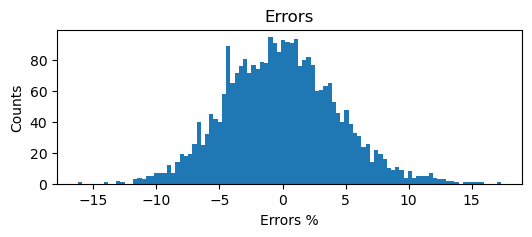

Mean Absolute errors : 3.50 %


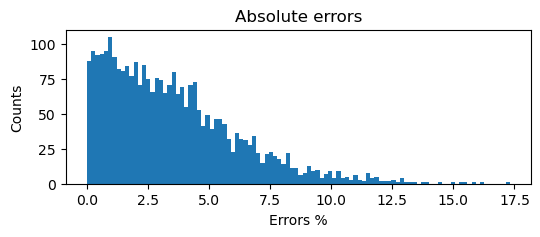

In [8]:
#X predictions
predictions, time = series.time_model(model, X)
print(f"Computation time: {time:.1f} s")

#error analysis
series.analyze_errors(predictions, y, relative=True, percents=True, title="Errors")
series.analyze_errors(predictions, y, relative=True, percents=True, absolute=True, title="Absolute errors")

## Global interpretability

### PDP

We can draw Partial Dependance Plots (PDP) 

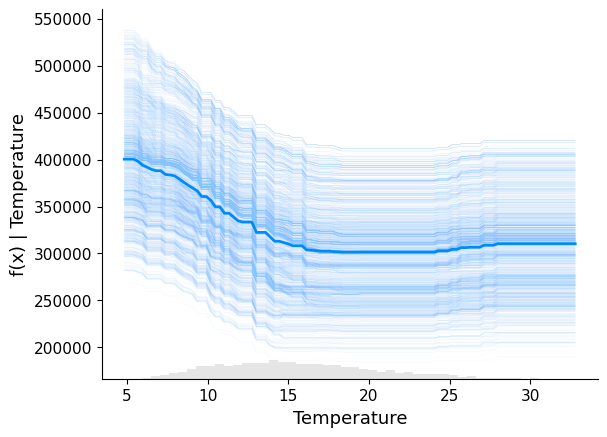

In [9]:
pdp.draw(model, X, "Temperature", npoints=100)

### ALE

We can draw 1st or 2nd order Accumulated Local Effects (ALE) plots, for continous or discrete variables.

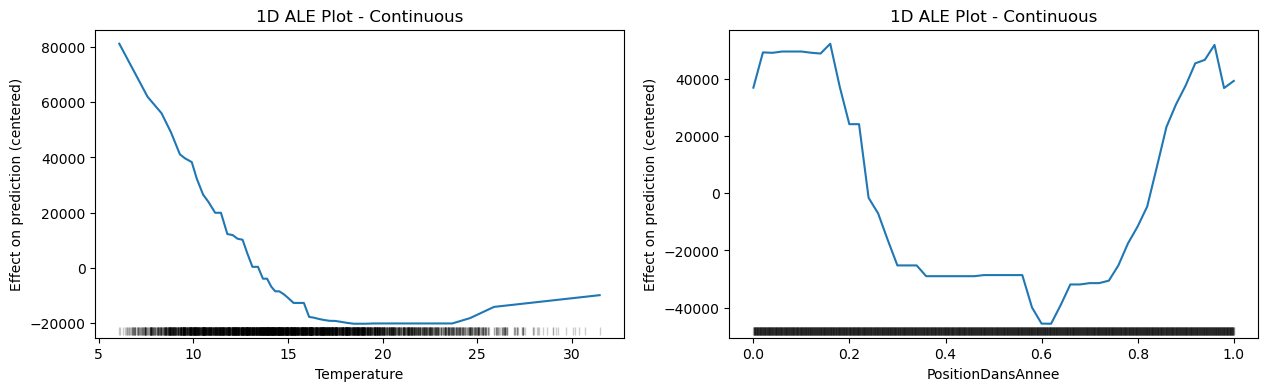

In [10]:
#first order effects
features = ["Temperature", "PositionDansAnnee"]
ale.draw_1d(model, X, features)

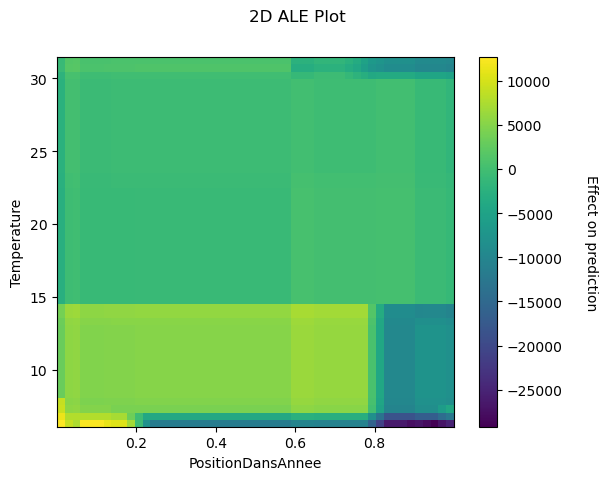

In [11]:
#second order effects
ale.draw_2d(model, X, features)

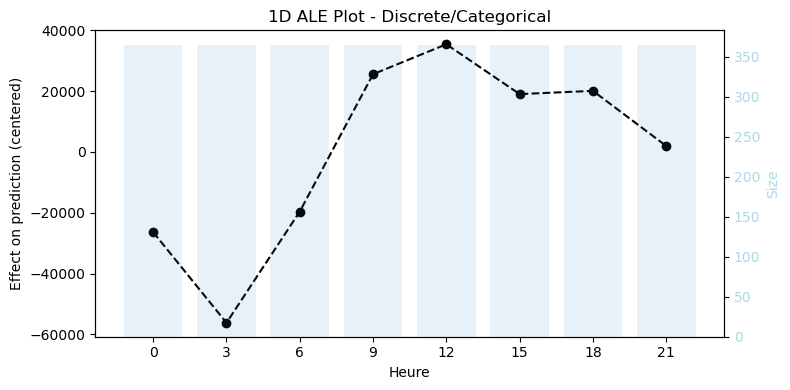

In [12]:
#categorical variables
ale.draw_1d(model, X, "Heure", feature_type="discrete")

Other parameters include:
- include_CI: draw confidence intervals
- grid_size: size of grid for discretization

## Shapley

To compute Shapley values, which must choose an algorithm from:
- Permutation SHAP
- Kernel SHAP
- Monte Carlo
- Exact (slow unless model is a monovariate GAM)

Details on each can be found in the documentation. 

In [13]:
algo = "monte_carlo"
params = {"n_coalitions":10, "n_approx":1, "do_double":True}

explainer = shapley.explainers.Shapley(model, algo=algo, col_mapping=col_mapping, **params)

In the previous call using Monte Carlo, the chosen parameters are:
- n_coalitions: number of sampled coalitions
- n_approx: number of background samples for each coalition
- do_double: sample different background for $v_x(S)$ and $v_x(S \cup \{j\}$

Then, you must fit the explainer on the background values and chosen features.

In [14]:
explainer.fit(background)

background_data = explainer.background_dict
print("Expectation: ",np.round(background_data["background_expectation"],1))

Expectation:  326495.4


Now, you can call the explainer on the values to explain, and plot the estimated parts.

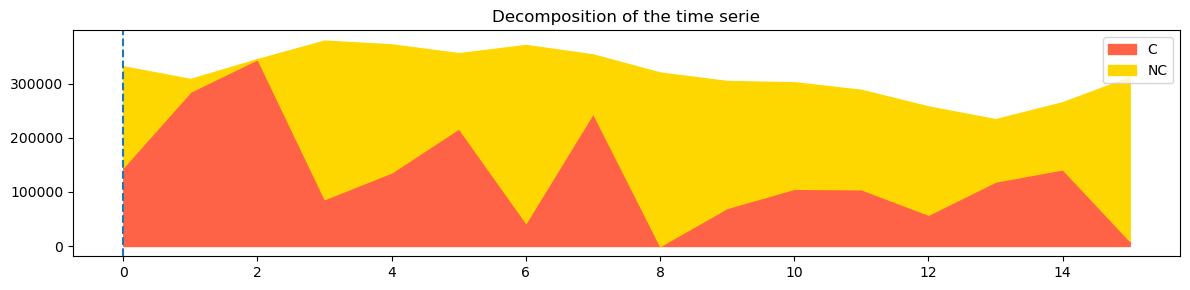

In [15]:
parts = explainer(Xws)
plots.show_sum(parts, color_mapping={"C":"tomato","NC":"gold"})

The estimation doesn't seem so great. We decide to increase the number of coalitions and background samples (this will also increase the computation time).

We call the whole pipeline directly, and give true information relative to X for more detailed errors.


Total computations done in 0.18 min
efficiency error: 5.38 %


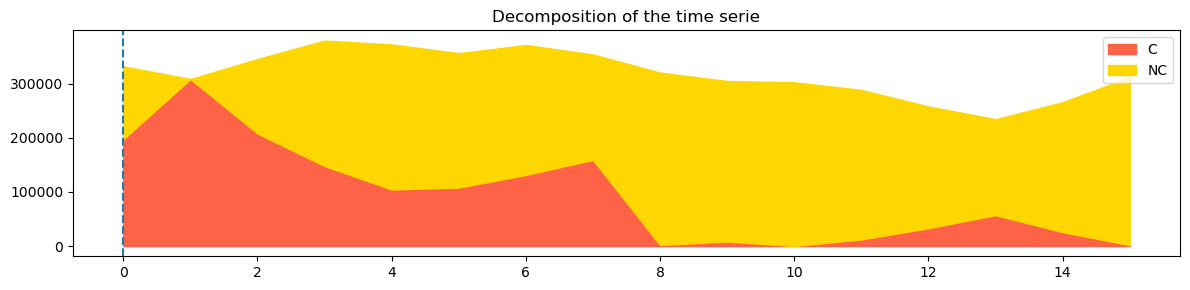

In [19]:
algo = "monte_carlo"
params = {"n_coalitions":100, "n_approx":10}

background_dict = {"background_y":background_y}
X_dict = {"y":yws}

parts, errors_dict, explainer = shapley.analysis.pipeline(
    model, background, Xws, algo, col_mapping=col_mapping, features=features,
    background_dict=background_dict,
    X_dict=X_dict,
    return_all=True,
    **params)

explainer.print_shap_errors()
plots.show_sum(parts, color_mapping={"C":"tomato","NC":"gold"})

This looks much better. The described errors correspond to:
- efficiency error : between the sum of estimated parts and model prediction

We can see that the climate (e.g temperature) has much more impact in the winter.